In [3]:
# import neessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
import pickle

In [4]:
with open("intermediate/dfs_dict.pickle", "rb") as f:
    dfs_dict = pickle.load(f)

df_solar = dfs_dict["Solar"]

In [ ]:
df_solar_only_na = df_solar[df_solar["ac_voltage"].isna()]
print(df_solar_only_na)
#df_solar_only_na.to_csv("intermediate/solar_only_nas.csv")

In [ ]:
df_solar_only_na["asset_id"].unique()

array([411, 412])

In [ ]:
print(f"All rows for asset 411: {df_solar[df_solar['asset_id']==411].shape[0]}")
print(f"All rows for asset 412: {df_solar[df_solar['asset_id']==412].shape[0]}\n")
print(f"Null rows for asset 411: {df_solar_only_na[df_solar_only_na['asset_id']==411].shape[0]}")
print(f"Null rows for asset 412: {df_solar_only_na[df_solar_only_na['asset_id']==412].shape[0]}")

All rows for asset 411: 49925
All rows for asset 412: 49797

Null rows for asset 411: 49925
Null rows for asset 412: 49797


So, all rows for assets 411 and 412 have NAs in the cols ac_current and ac_voltage

#### Fill NAs

AC power = AC current * AC voltage

ac_voltage < 220 and NAs = 230 as is the common voltage in Europe, assuming short-circuits not happening in the period in analysis

ac_current = ac_power/ac_voltage

In [ ]:
df_solar.loc[(df_solar["ac_voltage"] < 220) | df_solar["ac_voltage"].isna(), "ac_voltage"] = 230
df_solar.loc[df_solar["ac_current"].isna(), "ac_current"] = df_solar.loc[df_solar["ac_current"].isna(), "ac_power"]/df_solar.loc[df_solar["ac_current"].isna(), 
                                                                                                                                 "ac_voltage"]
df_solar[(df_solar["asset_id"]==411) | (df_solar["asset_id"]==412)]

asset_id              read_at  ac_power  ac_voltage  ac_current  \
3109038       411  2022-01-01 07:40:00       0.0       230.0    0.000000   
3109039       411  2022-01-01 07:50:00       0.0       230.0    0.000000   
3109040       411  2022-01-01 08:00:00       0.0       230.0    0.000000   
3109041       411  2022-01-01 08:10:00     259.0       230.0    1.126087   
3109042       411  2022-01-01 08:20:00     531.0       230.0    2.308696   
...           ...                  ...       ...         ...         ...   
3208755       412  2024-01-09 13:20:00    1857.0       230.0    8.073913   
3208756       412  2024-01-09 13:30:00    2015.0       230.0    8.760870   
3208757       412  2024-01-09 13:40:00    2114.0       230.0    9.191304   
3208758       412  2024-01-09 13:50:00    1459.0       230.0    6.343478   
3208759       412  2024-01-09 14:00:00    4352.0       230.0   18.921739   

         dc_power  dc_voltage  dc_current  farm  
3109038       0.0      482.74       0.000     4  
3109039       0.0      519.87       0.000     4  
3109040       0.0      527.25       0.000     4  
3109041     188.0      456.33       0.419     4  
3109042     349.0      479.84       0.733     4  
...           ...         ...         ...   ...  
3208755    1877.0      518.82       3.621     4  
3208756    2047.0      537.71       3.808     4  
3208757    2136.0      543.88       3.929     4  
3208758    1465.0      511.86       2.864     4  
3208759    4438.0      521.15       8.518     4  

[99722 rows x 9 columns]

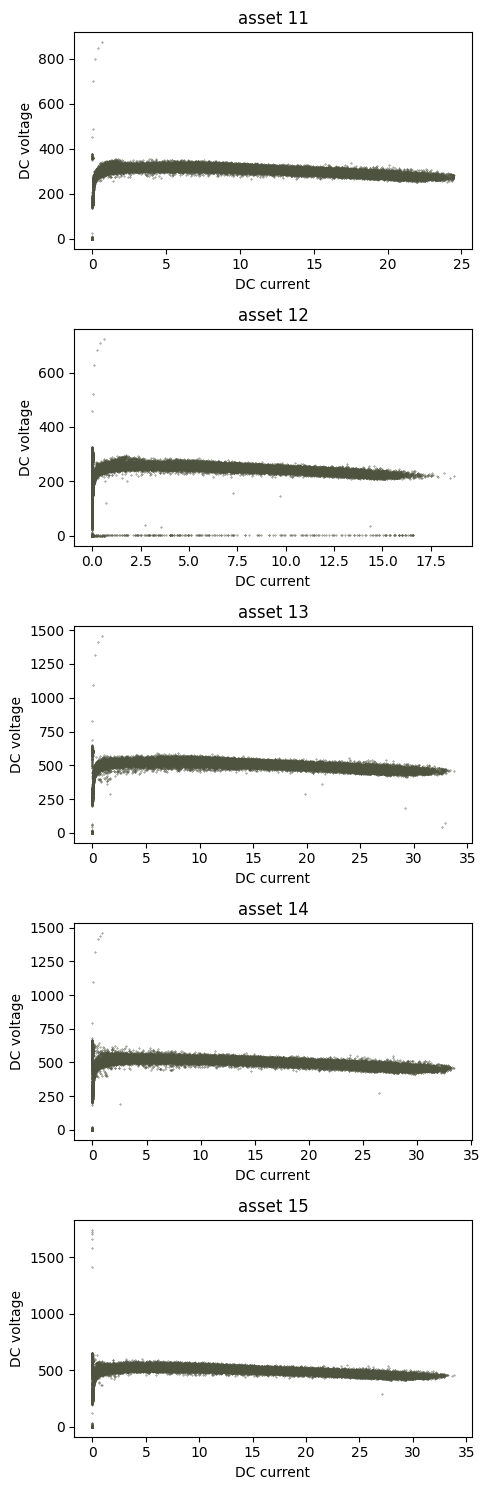

In [ ]:
plot = 1
assets = df_solar["asset_id"].unique()[:5]
n_plots = 5
plt.figure(figsize=(5, n_plots*3))
for asset, subset in df_solar[df_solar["asset_id"].isin(assets)].groupby("asset_id"):
    plt.subplot(n_plots, 1, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('DC current')
    plt.ylabel('DC voltage')
    plt.scatter(subset["dc_current"], subset["dc_voltage"], c="#4E5340", s=0.1)
    plot += 1
plt.tight_layout()
plt.show()

try a "logical" way to identify and remove outliers:

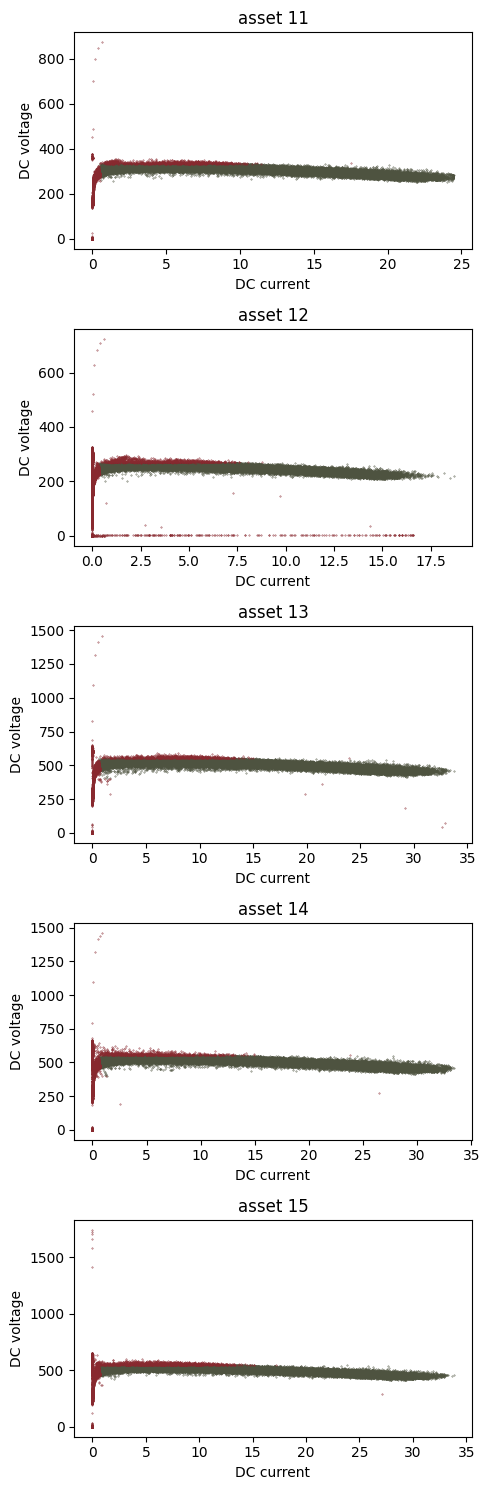

In [ ]:
plot = 1
assets = df_solar["asset_id"].unique()[:5]
n_plots = 5
plt.figure(figsize=(5, n_plots*3))
for asset, subset in df_solar[df_solar["asset_id"].isin(assets)].groupby("asset_id"):
    plt.subplot(n_plots, 1, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('DC current')
    plt.ylabel('DC voltage')
    _subset = subset[(subset["dc_power"] > subset["dc_power"].max()*0.02) & 
                     (subset["dc_voltage"] < (subset["dc_voltage"].median())*1.1) & 
                     (subset["dc_voltage"] > (subset["dc_voltage"].median())*0.80)]
    outliers = subset[~subset.index.isin(_subset.index)]
    plt.scatter(_subset["dc_current"], _subset["dc_voltage"], c="#4E5340", s=0.1)
    plt.scatter(outliers["dc_current"], outliers["dc_voltage"], c='#88292F', s=0.1)    
    plot += 1
plt.tight_layout()
plt.show()

test the DBSCAN method to identify outliers:

Number of outliers for Asset 11: 2164


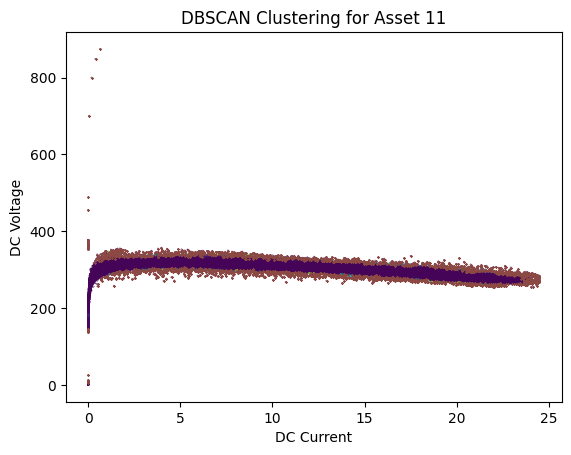

Number of outliers for Asset 12: 1338


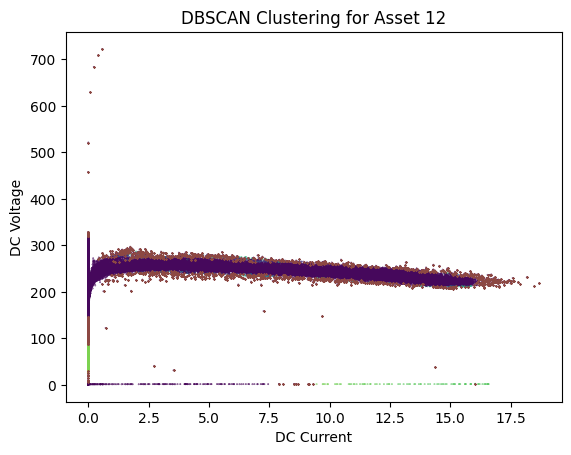

Number of outliers for Asset 13: 6232


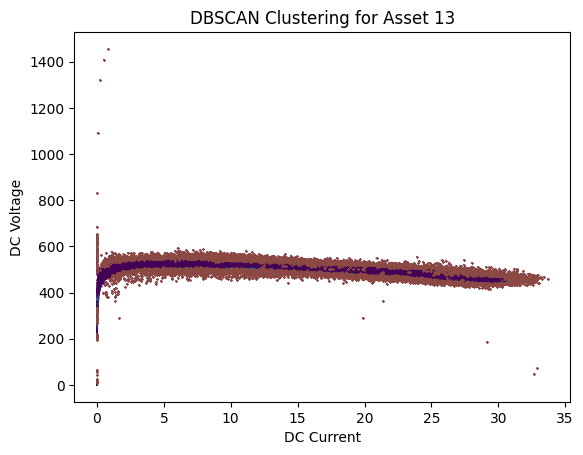

Number of outliers for Asset 14: 5964


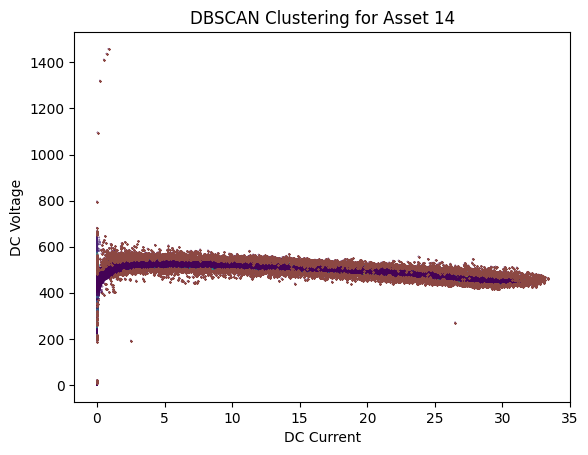

Number of outliers for Asset 15: 6285


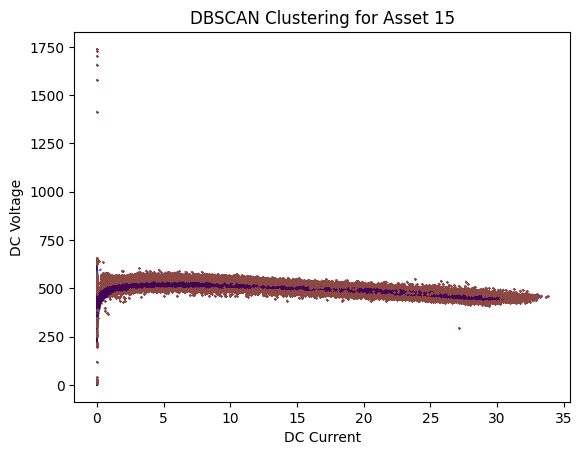

In [ ]:
# Define the DBSCAN parameters
eps = 0.3
min_samples = 5

# Iterate over the first 5 assets
for asset_id in df_solar['asset_id'].unique()[:5]:
    # Filter the data for the current asset
    filtered_data = df_solar[df_solar['asset_id'] == asset_id][['dc_current', 'dc_voltage']]

    # Create the DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the data
    dbscan.fit(filtered_data)

    # Get the labels of the data points
    labels = dbscan.labels_

    # Identify the outliers
    outliers = np.where(labels == -1)[0]

    # Print the number of outliers
    print(f"Number of outliers for Asset {asset_id}:", len(outliers))

    # Plot the data with the outliers highlighted
    plt.scatter(filtered_data['dc_current'], filtered_data['dc_voltage'], c=labels, label = "Remaining Points" , s=0.1)
    plt.scatter(filtered_data.iloc[outliers, 0], filtered_data.iloc[outliers, 1], c="#8C4843", marker="x", label = "Outlier",s=1)
    plt.title(f'DBSCAN Clustering for Asset {asset_id}')
    plt.xlabel('DC Current')
    plt.ylabel('DC Voltage')
    plt.show()




test the robust covariance method to identify the outliers:

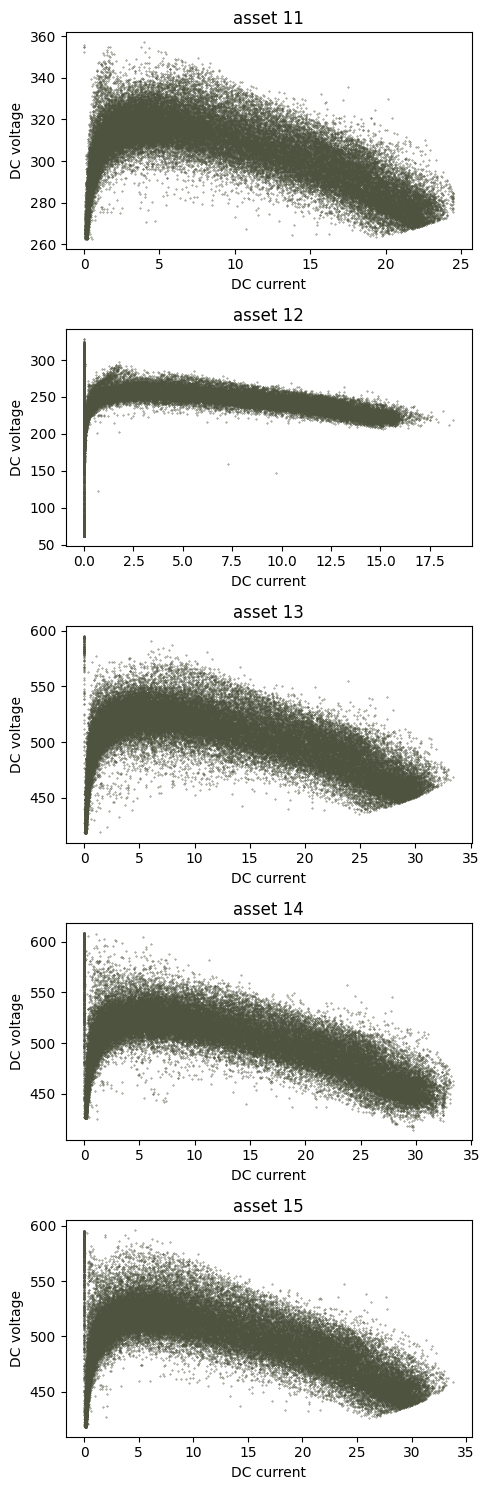

In [ ]:
plot = 1
assets = df_solar["asset_id"].unique()[:5]
n_plots = 5
plt.figure(figsize=(5, n_plots*3))
for asset, subset in df_solar[df_solar["asset_id"].isin(assets)].groupby("asset_id"):
    plt.subplot(n_plots, 1, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('DC current')
    plt.ylabel('DC voltage')
    
    # Fit the Elliptic Envelope
    robust_cov = EllipticEnvelope().fit(subset[["dc_current", "dc_voltage"]])
    
    # Detect outliers using the robust covariance
    outliers = robust_cov.predict(subset[["dc_current", "dc_voltage"]]) == -1
    
    # Filter the subset to exclude outliers
    _subset = subset[~outliers]
    
    plt.scatter(_subset["dc_current"], _subset["dc_voltage"], c="#4E5340", s=0.1)
    plot += 1

plt.tight_layout()
plt.show()


The robust covariance method cuts out data points that should not be considered as outliers, and took 1min and 12 secs to run just 5 assets

Filter the solar df to exclude the outliers by applying the DBSCAN to the entire df

In [ ]:
# Initialize an empty DataFrame to store the filtered data
solar_without_out = pd.DataFrame()

# Group the DataFrame by "asset_id"
grouped = df_solar.groupby("asset_id")

# Iterate over each group
for asset_id, group_df in grouped:
    # Filter the data for the current asset
    filtered_data = group_df[['dc_current', 'dc_voltage']]

    median_dc_voltage = group_df["dc_voltage"].median()
    max_dc_power = group_df["dc_power"].max()

    # Create the DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the data
    dbscan.fit(filtered_data)

    # Get the labels of the data points
    labels = dbscan.labels_

    # Identify the outliers
    outliers = np.where(labels == -1)[0]

    # Apply the filtering conditions within each group, excluding outliers
    subset = group_df[(group_df["dc_power"] > group_df["dc_power"].max() * 0.02) & (~group_df.index.isin(outliers))& 
                       (group_df["dc_voltage"] < median_dc_voltage * 1.1) & 
                       (group_df["dc_voltage"] > median_dc_voltage * 0.80)]

    # Concatenate the filtered subset to the overall filtered DataFrame
    solar_without_out = pd.concat([solar_without_out, subset])


Confirm that the df was cleaned:

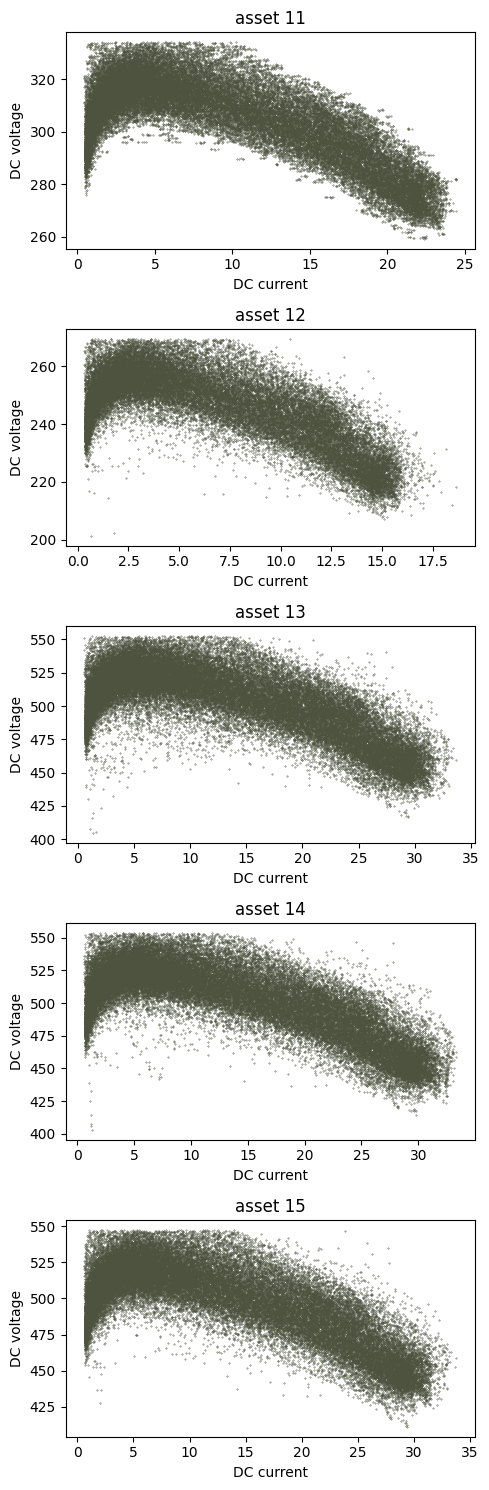

In [ ]:
plot = 1
assets = solar_without_out["asset_id"].unique()[:5]
n_plots = 5
plt.figure(figsize=(5, n_plots*3))
for asset, subset in solar_without_out[solar_without_out["asset_id"].isin(assets)].groupby("asset_id"):
    plt.subplot(n_plots, 1, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('DC current')
    plt.ylabel('DC voltage')
    plt.scatter(subset["dc_current"], subset["dc_voltage"], c="#4E5340", s=0.1)
    plot += 1
plt.tight_layout()
plt.show()

In [ ]:
solar_without_out.to_csv("intermediate/solar_df.csv")

#### Analyse the relation irradiance vs dc_power

In [6]:
solar_without_out = pd.read_csv("intermediate/solar_df.csv")

In [7]:
df_satellite = dfs_dict["Satellite"]

merged_df = solar_without_out[["read_at", "dc_voltage", "dc_current", "dc_power", "farm", "asset_id"]].merge(df_satellite[["read_at", "global_tilted_irradiance", "farm", "satellite_id"]], on=["read_at", "farm"], how="inner")
print(merged_df.head())
merged_df.to_csv("intermediate/solar_satellite_merged.csv")

               read_at  dc_voltage  dc_current  dc_power  farm  asset_id  \
0  2022-01-01 08:20:00     301.600       0.521   157.134     1        11   
1  2022-01-01 08:20:00     244.000       0.388    94.672     1        12   
2  2022-01-01 08:20:00     478.633       0.691   330.736     1        13   
3  2022-01-01 08:20:00     538.767       1.041   560.856     1        14   
4  2022-01-01 08:20:00     534.500       0.724   386.978     1        15   

   global_tilted_irradiance  satellite_id  
0                       9.0             1  
1                       9.0             1  
2                       9.0             1  
3                       9.0             1  
4                       9.0             1  


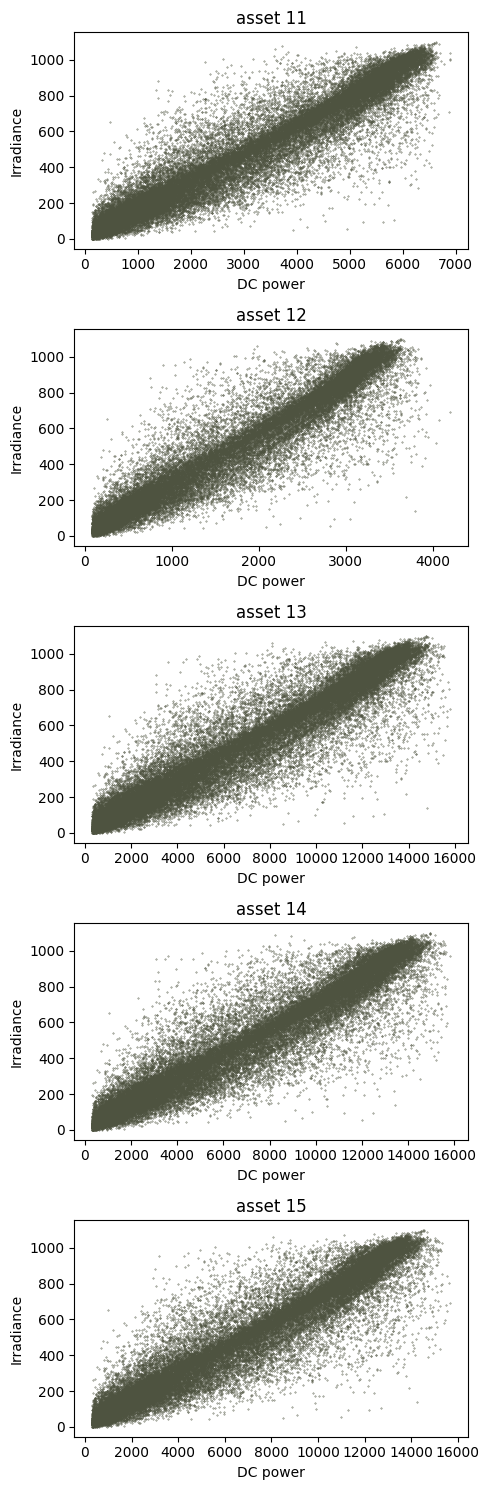

In [8]:
assets = merged_df["asset_id"].unique()[:5]

grouped_assets_solar_satellite = merged_df[merged_df["asset_id"].isin(assets)].groupby("asset_id")

plot = 1
n_plots = 5
plt.figure(figsize=(5, n_plots*3))
for asset, subset in grouped_assets_solar_satellite:
    plt.subplot(n_plots, 1, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('DC power')
    plt.ylabel('Irradiance')
    plt.scatter(subset["dc_power"], subset["global_tilted_irradiance"], c="#4E5340", s=0.1)
    plot += 1
plt.tight_layout()
plt.show()

Number of outliers for Asset 11: 42117


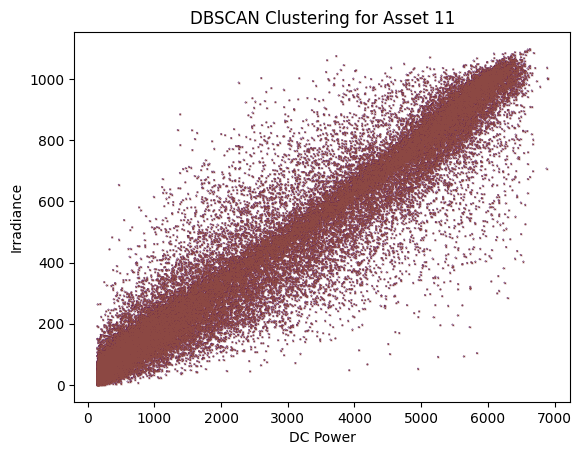

Number of outliers for Asset 12: 32434


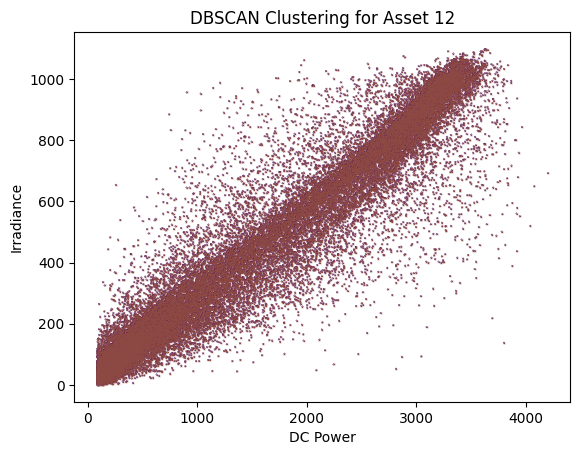

Number of outliers for Asset 13: 43434


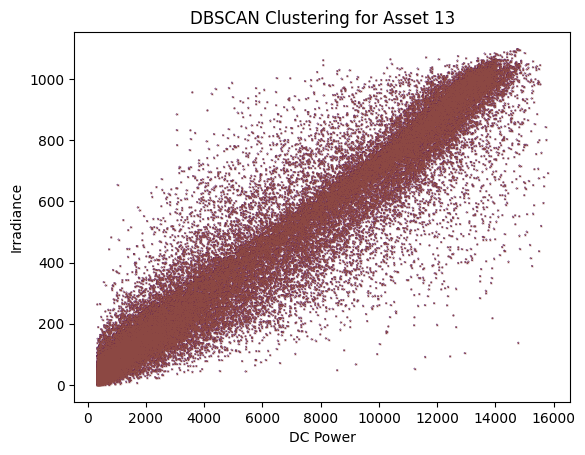

Number of outliers for Asset 14: 41873


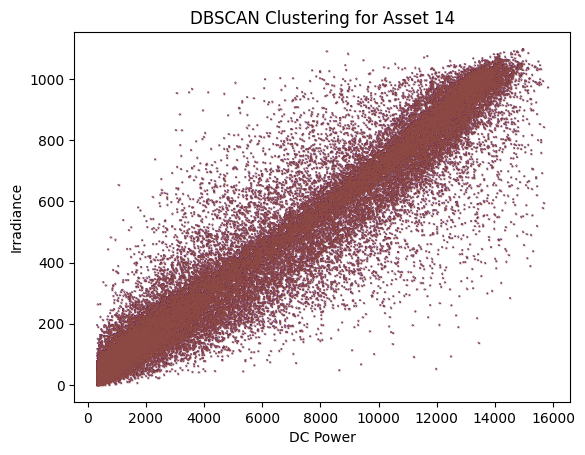

Number of outliers for Asset 15: 42096


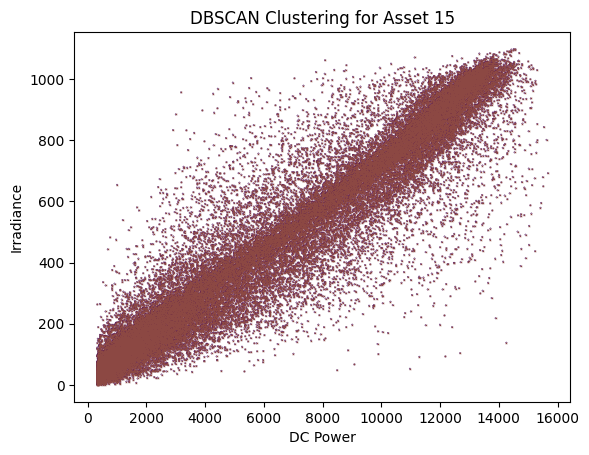

In [ ]:
# Define the DBSCAN parameters
eps = 0.3
min_samples = 5

# Iterate over the first 5 assets
for asset_id in assets:
    # Filter the data for the current asset
    filtered_data = merged_df[merged_df['asset_id'] == asset_id][['dc_power', 'global_tilted_irradiance']]

    # Create the DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the data
    dbscan.fit(filtered_data)

    # Get the labels of the data points
    labels = dbscan.labels_

    # Identify the outliers
    outliers = np.where(labels == -1)[0]

    # Print the number of outliers
    print(f"Number of outliers for Asset {asset_id}:", len(outliers))

    # Plot the data with the outliers highlighted
    plt.scatter(filtered_data['dc_power'], filtered_data['global_tilted_irradiance'], c=labels, label = "Remaining Points" , s=0.1)
    plt.scatter(filtered_data.iloc[outliers, 0], filtered_data.iloc[outliers, 1], c="#8C4843", marker="x", label = "Outlier",s=0.1)
    plt.title(f'DBSCAN Clustering for Asset {asset_id}')
    plt.xlabel('DC Power')
    plt.ylabel('Irradiance')
    plt.show()


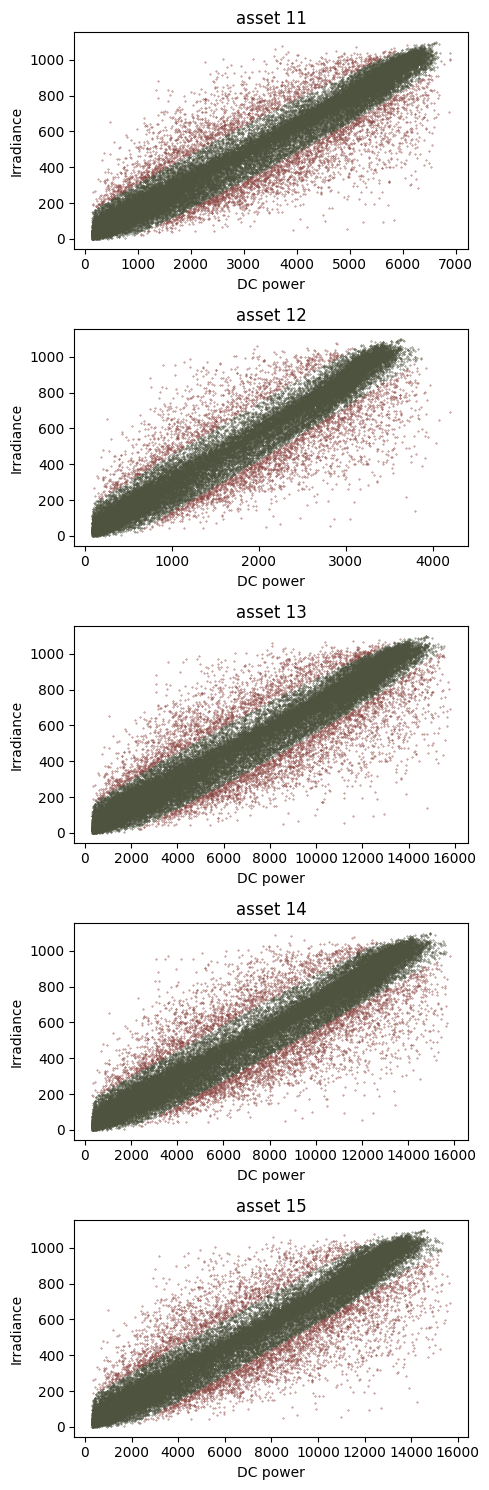

In [ ]:
plot = 1
n_plots = 5
plt.figure(figsize=(5, n_plots*3))
for asset, subset in grouped_assets_solar_satellite:
    plt.subplot(n_plots, 1, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('DC power')
    plt.ylabel('Irradiance')
    
    # Fit the Elliptic Envelope
    robust_cov = EllipticEnvelope().fit(subset[["dc_power", "global_tilted_irradiance"]])
    
    # Detect outliers using the robust covariance
    outliers = robust_cov.predict(subset[["dc_power", "global_tilted_irradiance"]]) == -1
    
    # Filter the subset to exclude outliers
    asset_inliers = subset[~outliers]
    asset_outliers = subset[outliers]
    
    plt.scatter(asset_inliers["dc_power"], asset_inliers["global_tilted_irradiance"], c="#4E5340", s=0.1)
    plt.scatter(asset_outliers["dc_power"], asset_outliers["global_tilted_irradiance"], c="#8C4843", s=0.1)

    plot += 1

plt.tight_layout()
plt.show()

In [4]:
merged_df = pd.read_csv("intermediate/solar_satellite_merged.csv")

In [5]:
# Initialize an empty DataFrame to store the filtered data

df_solar_satellite = pd.DataFrame()

# Group the DataFrame by "asset_id"
grouped = merged_df.groupby("asset_id")

# Define robust covariance parameters
contamination = 0.05  # Expected fraction of outliers

# Iterate over each group
for asset_id, group_df in grouped:
    # Fit the Elliptic Envelope
    robust_cov = EllipticEnvelope(contamination=contamination).fit(group_df[["dc_power", "global_tilted_irradiance"]])
    
    # Detect outliers using the robust covariance
    outliers = robust_cov.predict(group_df[["dc_power", "global_tilted_irradiance"]]) == -1
    
    # Apply the filtering conditions within each group, excluding outliers
    subset = group_df[~outliers]
    
    # Concatenate the filtered subset to the overall filtered DataFrame
    df_solar_satellite = pd.concat([df_solar_satellite, subset])


KeyboardInterrupt: 

In [1]:
df_solar_satellite.to_csv("intermediate/df_solar_satellite.csv")

NameError: name 'df_solar_satellite' is not defined

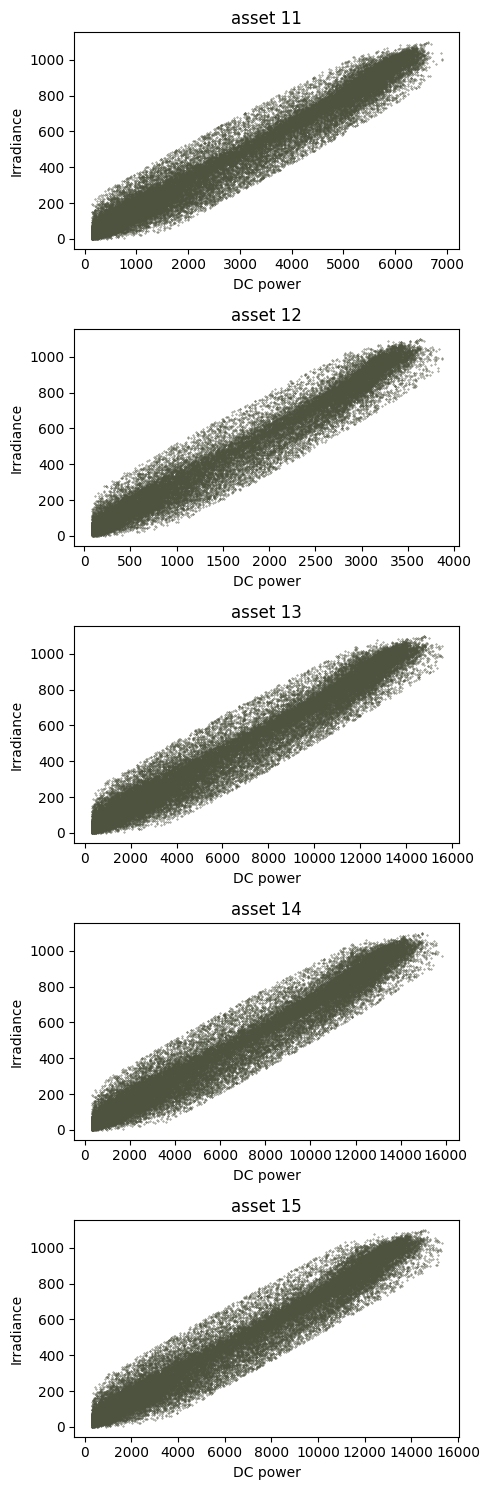

In [11]:
# Plotting
plot = 1
n_plots = 5
assets = df_solar_satellite["asset_id"].unique()[:5]
grouped_solar_satellite = df_solar_satellite[df_solar_satellite["asset_id"].isin(assets)]
plt.figure(figsize=(5, n_plots*3))
for asset, subset in grouped_solar_satellite.groupby("asset_id"):
    plt.subplot(n_plots, 1, plot)
    plt.title(f"asset {asset}")
    plt.xlabel('DC power')
    plt.ylabel('Irradiance')
    plt.scatter(subset["dc_power"], subset["global_tilted_irradiance"], c="#4E5340", s=0.1)
    plot += 1

plt.tight_layout()
plt.show()